# Dealing with long-range interactions

## Background

The Coulomb interactions in materials that are at least partly ionic give rise to long-range contributions to the forces and allows the system to sustain a finite dielectric displacement in the long-wavelength limit ($\vec{q}\rightarrow \vec{0}$).
This effect gives rise to a splitting of the longitudinal optical (LO) and transverse optical (TO) modes for $\vec{q}\rightarrow \vec{0}$ that varies with the direction of approach (i.e. the direction of the momentum vector $\vec{q}$).
To obtain the correct LO-TO splitting one commonly applies a so-called non-analytic term correction (NAC; see [Gonze *et al.* (1994)](#GonChaAll94) and [Gonze and Lee (1997)](#GonLee97)), which requires knowledge of the Born effective charges (BECs) $\mathcal{Z}_{\alpha\beta}$ and the dielectric constant $\varepsilon_{\alpha\beta}$, both of which are in general tensorial quantities.
The NAC can be handled, e.g., by [**phonopy**](https://phonopy.github.io/phonopy/formulation.html#non-analytical-term-correction-theory).

The long-range nature of the ionic interactions also poses a challenge when constructing force constant expansions (FCEs).
In such cases one typically observes a slow and often non-monotonic convergence of the FCE with system size that in many cases renders it near impossible to obtain converged results.
To circumvent this problem, one can separate the force constants into a long-ranged (Coulomb) and a short-ranged part, where the former contribution can be calculated using the same quantities as the NAC, namely the BECs and the dielectric constant.

In practice, one (1) substracts the forces from the Coulomb interaction (screened by the dielectric tensor) from the reference forces, (2) trains a (short-ranged) FCE to the remaining (short-ranged) forces, and (3) adds back the long-range contributions to the force constants.
The thus-obtained force constants can then be used, e.g., to compute the phonon dispersion, the calculation of which should include the NAC.

This effects described above as well as the correction procedure are demonstrated for the case of sodium chloride (NaCl) below.

In [1]:
import numpy as np
from ase import Atoms
from ase.io import read
from hiphive import ClusterSpace, StructureContainer, ForceConstantPotential
from trainstation import Optimizer
from hiphive.utilities import prepare_structures
from matplotlib import pyplot as plt
from phonopy import Phonopy
from phonopy.file_IO import parse_BORN

from phonopy.structure.atoms import PhonopyAtoms

## Non-analytic term correction

To begin with we consider a standard **phonopy** calculation with and without NAC to illustrate the impact on the phonon dispersion.
First we set up a phonopy object with a set of force constants.

In [2]:
# Set up phonopy object
unitcell = read('NaCl_unitcell.xyz')
unitcell_phonopy = PhonopyAtoms(symbols=unitcell.get_chemical_symbols(), 
                                scaled_positions=unitcell.get_scaled_positions(), cell=unitcell.cell)

phonon = Phonopy(unitcell_phonopy,
                 np.diag([4, 4, 4]),
                 primitive_matrix=[[0, 0.5, 0.5],
                                   [0.5, 0, 0.5],
                                   [0.5, 0.5, 0]])
# The following call generates the displacement dataset.
phonon.generate_displacements()

# In this example we already have a set of forces precalculated,
# which we load and use to set up the force constants.
displaced_supercells_with_forces = read('supercells_with_forces.xyz', index=':')
forces = [supercell.get_forces() for supercell in displaced_supercells_with_forces]
phonon.set_forces(forces)
phonon.produce_force_constants()

Next we compute the phonon dispersion a long a certain Brillouin zone path that will be reused below.

In [3]:
path_labels = ['G', 'X', 'K', '$\Gamma$','L']
path = [
    np.linspace([0.0, 0.0, 0.0], [0.5, 0.0, 0.0]),
    np.linspace([0.5, 0.0, 0.0], [0.5, 0.5, 0.0]),
    np.linspace([0.5, 0.5, 0.0], [0.0, 0.0, 0.0]),
    np.linspace([0.0, 0.0, 0.0], [0.5, 0.5, 0.5])]
phonon.set_band_structure(path)
dispersion_phonopy_without_NAC = phonon.get_band_structure_dict()

Now we add the NAC using parameters read from a file (`BORN`) and recompute the dispersion.
Please consult the [**phonopy** documentation](https://phonopy.github.io/phonopy/input-files.html#born-optional) for a description of this file.
Note that can also provide the BECs and the dielectric constant [directly via **phonopy**'s Python API](https://phonopy.github.io/phonopy/phonopy-module.html#non-analytical-term-correction).

In [4]:
phonon.nac_params = parse_BORN(phonon.primitive, filename='BORN')
phonon.set_band_structure(path)  # Force recalculation of dispersion
dispersion_phonopy_with_NAC = phonon.get_band_structure_dict()

Finally, we plot the two dispersions.

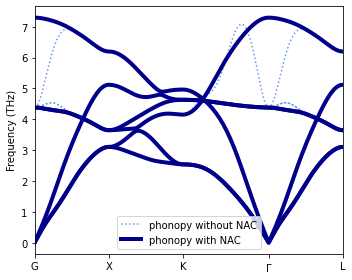

In [5]:
fig, ax = plt.subplots(figsize=(5, 4))

# Plot dispersion without NAC
lines = ax.plot(np.hstack(dispersion_phonopy_without_NAC['distances']),
                np.vstack(dispersion_phonopy_without_NAC['frequencies']),
                c='cornflowerblue', linestyle='dotted')
lines[0].set_label('phonopy without NAC')

# Plot dispersion with NAC
lines = ax.plot(np.hstack(dispersion_phonopy_with_NAC['distances']),
                np.vstack(dispersion_phonopy_with_NAC['frequencies']),
                c='darkblue', linestyle='solid', lw=4)
lines[0].set_label('phonopy with NAC')

# Show q-point labels on x-axis
xticks = {}
for k, (dist, lbl) in enumerate(zip(dispersion_phonopy_with_NAC['distances'], path_labels)):
    xticks[dist[0]] = lbl
xticks[dist[-1]] = path_labels[-1]
xpts = list(xticks.keys())
ax.set_xlim(xpts[0], xpts[-1])
ax.set_xticks(xpts)
ax.set_xticklabels(xticks.values())

# Other settings
ax.set_ylabel('Frequency (THz)')
ax.legend()

plt.tight_layout()

## FC extraction with long-range corrections

We now proceed to extract the FCs by regression via **hiphive**.
Here, we use the same structures as for the "pure" **phonopy** analysis above, in which only one atom is displaced per structure.
Even though, in general, in the regression approach one would use structures with more general displacement patterns.

In [6]:
cutoff = 11.0
cs = ClusterSpace(unitcell, [cutoff])
sc = StructureContainer(cs)

supercell_ph = phonon.get_supercell()
supercell = Atoms(cell=supercell_ph.cell,
                  positions=supercell_ph.positions,
                  numbers=supercell_ph.numbers,
                  pbc=True)
for structure in prepare_structures(displaced_supercells_with_forces, supercell):
    sc.add_structure(structure)

Primitive cell:
    Formula: ClNa
    Cell:
        [  0.00000   2.84515   2.84515]
        [  2.84515   0.00000   2.84515]
        [  2.84515   2.84515   0.00000]
    Basis:
        Na  [  0.00000   0.00000   0.00000]
        Cl  [  0.50000   0.50000   0.50000]

Crystal symmetry:
    Spacegroup:          Fm-3m (225)
    Unique site:         2
    Symmetry operations: 48
    symprec:             1.00e-05

Cutoffs:
    Maximum cutoff: 11.0
    Found 2 center atoms with 334 images totaling 336 atoms

Clusters:
    Clusters: {2: 501}
    Total number of clusters: 501

Orbits:
    Orbits: {2: 23}
    Total number of orbits: 23

Eigentensors:
    Eigentensors: {2: 76}
    Total number of parameters: 76

Constraints:
    Acoustic: True
    Number of degrees of freedom: {2: 74}
    Total number of degrees of freedom: 74


First we apply the approach directly without special consideration of long-range (Coulomb) forces.

In [7]:
# Train parameters by regression
opt = Optimizer(sc.get_fit_data())
opt.train()
fcp = ForceConstantPotential(cs, opt.parameters)

# Extract second-order FCs for the given supercell
fc2 = fcp.get_force_constants(supercell).get_fc_array(order=2)
phonon.set_force_constants(fc2)
phonon.set_band_structure(path)
dispersion_hiphive_without_LRC = phonon.get_band_structure_dict()

The results ("hiphive with NAC but without LRC") reveal "oscillations" in the optical branches in the approach to $\Gamma$, i.e. $\vec{q}\rightarrow\vec{0}$.

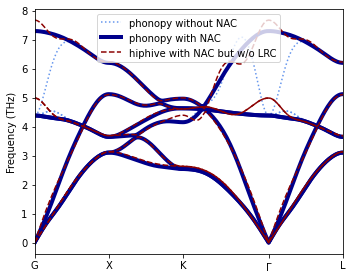

In [8]:
fig, ax = plt.subplots(figsize=(5, 4))

# Plot dispersion from phonopy without NAC
lines = ax.plot(np.hstack(dispersion_phonopy_without_NAC['distances']),
                np.vstack(dispersion_phonopy_without_NAC['frequencies']),
                c='cornflowerblue', linestyle='dotted')
lines[0].set_label('phonopy without NAC')

# Plot dispersion from phonopy with NAC
lines = ax.plot(np.hstack(dispersion_phonopy_with_NAC['distances']),
                np.vstack(dispersion_phonopy_with_NAC['frequencies']),
                c='darkblue', linestyle='solid', lw=4)
lines[0].set_label('phonopy with NAC')

# Plot dispersion from hiphive with NAC but without LRC
lines = ax.plot(np.hstack(dispersion_hiphive_without_LRC['distances']),
                np.vstack(dispersion_hiphive_without_LRC['frequencies']),
                c='darkred', linestyle='dashed')
lines[0].set_label('hiphive with NAC but w/o LRC')

# Other settings
ax.set_xlim(xpts[0], xpts[-1])
ax.set_xticks(xpts)
ax.set_xticklabels(xticks.values())
ax.set_ylabel('Frequency (THz)')
ax.legend()

plt.tight_layout()

Now we repeat the regression approach but this time we remove the long-range (Coulomb) forces before training the short-ranged FCs and then add the long and short-ranged contributions to the second-order FCs before evaluating the phonon dispersion. For computing the contribution of the long-range forces to the second-order FCs, we use functionality from **phonopy**.

In [9]:
# Obtain the long-range (Coulomb) contribution to the second-order FCs
phonon.set_force_constants(np.zeros((len(supercell), len(supercell), 3, 3)))
dynmat = phonon.get_dynamical_matrix()
dynmat.make_Gonze_nac_dataset()
fc2_LR = -dynmat.get_Gonze_nac_dataset()[0]

# Remove the corresponding forces from the training data
displacements = np.array([fs.displacements for fs in sc])
M, F = sc.get_fit_data()
F -= np.einsum('ijab,njb->nia', -fc2_LR, displacements).flatten()

# ... and fit the remaining forces to a regular FC expansion
opt = Optimizer((M, F))
opt.train()
fcp = ForceConstantPotential(cs, opt.parameters)
fc2_SR = fcp.get_force_constants(supercell).get_fc_array(order=2)

# Finally, we add the two contributions to the second-order FCs and compute the band structure
phonon.set_force_constants(fc2_SR + fc2_LR)
phonon.set_band_structure(path)
dispersion_hiphive_with_LRC = phonon.get_band_structure_dict()

The resulting phonon dispersion ("hiphive with NAC and LRC") is in excellent agreement with the reference dispersion from **phonopy**.

In [10]:
fig, ax = plt.subplots(figsize=(5, 4))

# Plot dispersion from phonopy without NAC
lines = ax.plot(np.hstack(dispersion_phonopy_without_NAC['distances']),
                np.vstack(dispersion_phonopy_without_NAC['frequencies']),
                c='cornflowerblue', linestyle='dotted')
lines[0].set_label('phonopy without NAC')

# Plot dispersion from phonopy with NAC
lines = ax.plot(np.hstack(dispersion_phonopy_with_NAC['distances']),
                np.vstack(dispersion_phonopy_with_NAC['frequencies']),
                c='darkblue', linestyle='solid', lw=4)
lines[0].set_label('phonopy with NAC')

# Plot dispersion from hiphive with NAC but without LRC
lines = ax.plot(np.hstack(dispersion_hiphive_without_LRC['distances']),
                np.vstack(dispersion_hiphive_without_LRC['frequencies']),
                c='darkred', linestyle='dashed')
lines[0].set_label('hiphive with NAC but w/o LRC')

# Plot dispersion from hiphive with NAC and LRC
lines = ax.plot(np.hstack(dispersion_hiphive_with_LRC['distances']),
                np.vstack(dispersion_hiphive_with_LRC['frequencies']),
                c='goldenrod', linestyle='solid', lw=2)
lines[0].set_label('hiphive with NAC and LRC')

# Other settings
ax.set_xlim(xpts[0], xpts[-1])
ax.set_xticks(xpts)
ax.set_xticklabels(xticks.values())
ax.set_ylabel('Frequency (THz)')
ax.legend()

plt.tight_layout()

## FC extraction with folding
Next we will demonstrate that one can achive the same effect without LRC by instead using force-constant folding.

In `hiphive` the FCP is typically constructed for a supercell (denoted `supercell_1`). This FCP will not capture the longest ranged interactions in `supercell_1` since the cutoff is enforced to be smaller than L/2 of the supercell.

To circumvent this we construct a twice as large supercell, `supercell_2 = supercell_1.repeat(2)`, for which we construct the FCP and FCs. Next these FCs are folded back onto `supercell_1` which will therefore include all the long-ranged FCs in `supercell_1`.

By employing the FC folding trick we can thus recover the correct phonon dispersion with NAC without using the LRC above.


In [11]:
from hiphive.core.atoms import spos_to_atom

def get_index_offset(atoms, atoms_ref):
    """ Get index and offsets for atoms relative to atoms_ref.cell and positons """
    basis = atoms_ref.get_scaled_positions()
    spos = atoms_ref.cell.scaled_positions(atoms.positions)
    indices = []
    offsets = []
    for s in spos:
        a = spos_to_atom(s, basis)
        indices.append(a.site)
        offsets.append(a.offset)
    return indices, offsets

In [12]:
from hiphive.cutoffs import estimate_maximum_cutoff

max_cutoff = estimate_maximum_cutoff(supercell) - 0.001
print('Max cutoff', max_cutoff)
print('Supercell_1 cell:')
print(supercell.cell[:])

# setup supercell_2
supercell_2 = supercell.repeat(2)
cutoff_2 = 2 * max_cutoff 
print('Supercell_2 cell:')
print(supercell_2.cell[:])

Max cutoff 11.379602952351343
Supercell_1 cell:
[[22.7612059  0.         0.       ]
 [ 0.        22.7612059  0.       ]
 [ 0.         0.        22.7612059]]
Supercell_2 cell:
[[45.52241181  0.          0.        ]
 [ 0.         45.52241181  0.        ]
 [ 0.          0.         45.52241181]]


The following cell can take a minute or two to run due to the large supercells being added to the SC.    
Note that `repeat(2)` also repeats the displacements and forces.

In [13]:
cs = ClusterSpace(unitcell, [cutoff_2])
sc = StructureContainer(cs)
for i, structure in enumerate(prepare_structures(displaced_supercells_with_forces, supercell)):
    print('Adding', i, 'of', len(displaced_supercells_with_forces))
    structure_2 = structure.repeat(2)
    sc.add_structure(structure_2)

Primitive cell:
    Formula: ClNa
    Cell:
        [  0.00000   2.84515   2.84515]
        [  2.84515   0.00000   2.84515]
        [  2.84515   2.84515   0.00000]
    Basis:
        Na  [  0.00000   0.00000   0.00000]
        Cl  [  0.50000   0.50000   0.50000]

Crystal symmetry:
    Spacegroup:          Fm-3m (225)
    Unique site:         2
    Symmetry operations: 48
    symprec:             1.00e-05

Cutoffs:
    Maximum cutoff: 22.759205904702686
    Found 2 center atoms with 2450 images totaling 2452 atoms

Clusters:
    Clusters: {2: 4205}
    Total number of clusters: 4205

Orbits:
    Orbits: {2: 119}
    Total number of orbits: 119

Eigentensors:
    Eigentensors: {2: 541}
    Total number of parameters: 541

Constraints:
    Acoustic: True
    Number of degrees of freedom: {2: 539}
    Total number of degrees of freedom: 539
Adding 0 of 2
Adding 1 of 2


Next we train a FCP using the repeated training structures.     
This will cause the optimizer to print a condition number warning due to there being linearly dependent parameters. This us due to the fact that we are trying obtain FCs that are longer ranged than the original supercell allows for.

This warning is expected and not a problem here since our goal is to fold the resulting FCs back onto a small supercell.

In [14]:
opt = Optimizer(sc.get_fit_data(), train_size=1.0, fit_method='ridge')
opt.train()
print(opt)
fcp = ForceConstantPotential(cs, opt.parameters)
fcs = fcp.get_force_constants(supercell_2)

Condition number is large, 4.01630778978014e+19


===================== Optimizer ======================
seed                           : 42
fit_method                     : ridge
standardize                    : True
n_target_values                : 24576
n_parameters                   : 539
n_nonzero_parameters           : 539
parameters_norm                : 2.017593e+10
target_values_std              : 0.0005821223
rmse_train                     : 1.314636e-05
R2_train                       : 0.99949
AIC                            : -551359.3
BIC                            : -546988.3
alpha_optimal                  : 0.05336699
train_size                     : 24576
test_size                      : 0


In [15]:
# Folding of fcs onto original supercell
n_atoms = len(supercell)
indices, offsets = get_index_offset(supercell_2, supercell)
fc2_folded = np.zeros((n_atoms, n_atoms, 3, 3))

for i in range(n_atoms):
    for i2 in range(len(supercell_2)):
        j = indices[i2]
        fc2_folded[i, j] += fcs[i, i2]

In [16]:
# Next we'll obtain the phonon dispersion with the `fc2_folded`
phonon.set_force_constants(fc2_folded)
phonon.set_band_structure(path)
dispersion_hiphive_folding = phonon.get_band_structure_dict()

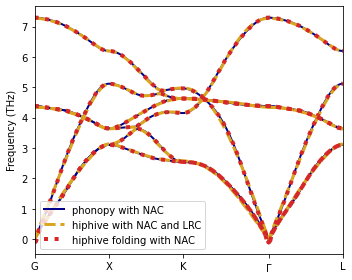

In [17]:
fig, ax = plt.subplots(figsize=(5, 4))

# Plot dispersion from phonopy with NAC
lines = ax.plot(np.hstack(dispersion_phonopy_with_NAC['distances']),
                np.vstack(dispersion_phonopy_with_NAC['frequencies']),
                c='darkblue', linestyle='solid', lw=2)
lines[0].set_label('phonopy with NAC')

# Plot dispersion from hiphive with NAC and LRC
lines = ax.plot(np.hstack(dispersion_hiphive_with_LRC['distances']),
                np.vstack(dispersion_hiphive_with_LRC['frequencies']),
                c='goldenrod', linestyle='--', lw=3)
lines[0].set_label('hiphive with NAC and LRC')

# Plot dispersion from hiphive folding with NAC
lines = ax.plot(np.hstack(dispersion_hiphive_folding['distances']),
                np.vstack(dispersion_hiphive_folding['frequencies']),
                c='tab:red', linestyle=':', lw=4.0)
lines[0].set_label('hiphive folding with NAC')


# Other settings
ax.set_xlim(xpts[0], xpts[-1])
ax.set_xticks(xpts)
ax.set_xticklabels(xticks.values())
ax.set_ylabel('Frequency (THz)')
ax.legend()

plt.tight_layout()

## References

* <a name="GonChaAll94">X. Gonze, J.-C. Charlier, D.C. Allan, and M.P. Teter</a>,
   *Interatomic force constants from first principles: The case of α-quartz*,
   [Physical Review B **50**, 13035(R) (1994)](https://doi.org/10.1103/PhysRevB.50.13035)

* <a name="GonLee97">X. Gonze and C. Lee</a>,
  *Dynamical matrices, Born effective charges, dielectric permittivity tensors, and interatomic force constants from density-functional perturbation theory*,
  [Physical Review B **55**, 10355 (1997)](https://doi.org/10.1103/PhysRevB.55.10355)</font>